In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [2]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

Generate stuff for whole team

In [3]:
team_stats_df = aps.generate_full_team_aggregate( 2017, drop_preseason=False )

In [4]:
print team_stats_df.shape
print team_stats_df.columns.values

(5132, 71)
[u'team' 'opp_team' u'week' 'year' 'score' 'opp_score' 'home_flag'
 'away_flag' 'tds' u'rush_att' u'rush_yds' u'pass_att' u'pass_yds'
 u'pass_cmp' u'pass_sack' u'kickoffs' u'punts' u'fg_miss' u'kickret_tds'
 u'punt_ret_tds' u'off_fumb_tot' u'kickoff_in_20' u'kickoff_touchback'
 u'fg_yds' u'fg_made' u'def_int_tds' u'def_frec_tds' u'def_misc_tds'
 u'def_safety' u'def_tkl' u'def_tkl_contributers' u'def_fumb_rec'
 u'def_fumb_forced' u'def_int' u'def_tkl_loss' u'def_sack' u'def_pass_def'
 'score_prev_4' 'opp_score_prev_4' 'home_flag_prev_4' 'away_flag_prev_4'
 'tds_prev_4' 'rush_att_prev_4' 'rush_yds_prev_4' 'pass_att_prev_4'
 'pass_yds_prev_4' 'pass_cmp_prev_4' 'pass_sack_prev_4' 'kickoffs_prev_4'
 'punts_prev_4' 'fg_miss_prev_4' 'kickret_tds_prev_4' 'punt_ret_tds_prev_4'
 'off_fumb_tot_prev_4' 'kickoff_in_20_prev_4' 'kickoff_touchback_prev_4'
 'fg_yds_prev_4' 'fg_made_prev_4' 'def_int_tds_prev_4'
 'def_frec_tds_prev_4' 'def_misc_tds_prev_4' 'def_safety_prev_4'
 'def_tkl_prev_4'

QB include most individual stats

In [5]:
n_weeks  = 4
min_year = 2009
max_year = 2017
wk_str   = str(n_weeks)

all_qb_data = pd.DataFrame()

# Get all the preseason data
# Can id by team, week, year
for year in range( min_year, max_year ):
    new_frame = gps.generate_stats( 'QB', year, season_type='Preseason' )
    new_frame['year'] = year
    all_qb_data = pd.concat( [all_qb_data, new_frame], ignore_index=True )

    
all_qb_data['week'] = all_qb_data['week']-4
    

# Get all the Kicker regular season data
# Can id by team, week, year
for year in range( min_year, max_year ):
    new_frame = gps.generate_stats( 'QB', year )
    new_frame['year'] = year
    all_qb_data = pd.concat( [all_qb_data, new_frame], ignore_index=True )
    
    
# Ignore some team stuff, can get from joining with team
all_qb_data = all_qb_data.drop( ['opp_team','home_flag','away_flag'],axis=1 )

# Generate previous rolling sum
agg_stuff = [
                'pass_yds', 
                'pass_tds',
                'pass_int', 
                'rush_yds', 
                'rush_tds', 
                'fumb_lost',
                'fumb_rec_tds', 
                'fumb_rec', 
                'fumb_forced', 
                'fumb_nforced',
                'pass_attempts', 
                'pass_complete', 
                'pass_incomplete',
                'pass_air_yds', 
                'pass_air_yds_max', 
                'sacks', 
                'sack_yards',
                'rush_att'
            ]
prev_qb = aps.calc_prev_player_stats( all_qb_data, agg_stuff )

# Combine present values with rolling sums
all_qb_data = pd.merge( all_qb_data, prev_qb, on=['player_id','year','week'] )

# Drop all the preseason stuff
all_qb_data = all_qb_data.loc[ all_qb_data['week']>0 ]

# Note if the data includes preseason stuff
# If the first four games, flag as preseason data included
# This is tricky, as can have a bye-week
# Therefore, group things, find the first n_weeks, and flag those as 1
inds = all_qb_data.groupby(['player_id','year'], as_index=False).nth( range(0, n_weeks) ).index.values

all_qb_data    [       'few_reg_weeks'] = 0
all_qb_data.loc[ inds, 'few_reg_weeks'] = 1

In [6]:
print all_qb_data.shape
print all_qb_data.columns.values

(3668, 40)
[u'player_id' u'team' u'week' u'pass_yds' u'pass_tds' u'pass_int'
 u'rush_yds' u'rush_tds' u'fumb_lost' u'fumb_rec_tds' u'fumb_rec'
 u'fumb_forced' u'fumb_nforced' u'pass_attempts' u'pass_complete'
 u'pass_incomplete' u'pass_air_yds' u'pass_air_yds_max' u'sacks'
 u'sack_yards' u'rush_att' 'year' 'pass_yds_prev_4' 'pass_tds_prev_4'
 'pass_int_prev_4' 'rush_yds_prev_4' 'rush_tds_prev_4' 'fumb_lost_prev_4'
 'fumb_rec_tds_prev_4' 'fumb_rec_prev_4' 'fumb_forced_prev_4'
 'fumb_nforced_prev_4' 'pass_attempts_prev_4' 'pass_complete_prev_4'
 'pass_incomplete_prev_4' 'pass_air_yds_prev_4' 'pass_air_yds_max_prev_4'
 'sacks_prev_4' 'sack_yards_prev_4' 'rush_att_prev_4']


In [7]:
all_qb_data.head()

,player_id,team,week,pass_yds,pass_tds,pass_int,rush_yds,rush_tds,fumb_lost,fumb_rec_tds,...,fumb_forced_prev_4,fumb_nforced_prev_4,pass_attempts_prev_4,pass_complete_prev_4,pass_incomplete_prev_4,pass_air_yds_prev_4,pass_air_yds_max_prev_4,sacks_prev_4,sack_yards_prev_4,rush_att_prev_4
1489,00-0019596,NE,1,378,2,1,9,0,0,0,...,0.0,0.0,41.0,25.0,16.0,153.0,44.0,2.0,-8.0,1.0
1490,00-0019596,NE,2,216,0,1,2,0,0,0,...,0.0,0.0,94.0,64.0,30.0,376.0,62.0,3.0,-18.0,2.0
1491,00-0019596,NE,3,277,1,0,0,0,0,0,...,0.0,0.0,127.0,78.0,49.0,444.0,67.0,3.0,-18.0,2.0
1492,00-0019596,NE,4,258,1,0,11,1,1,0,...,0.0,0.0,161.0,99.0,62.0,599.0,90.0,2.0,-11.0,5.0
1493,00-0019596,NE,5,215,2,0,-1,0,1,0,...,1.0,0.0,174.0,108.0,66.0,631.0,92.0,4.0,-34.0,10.0


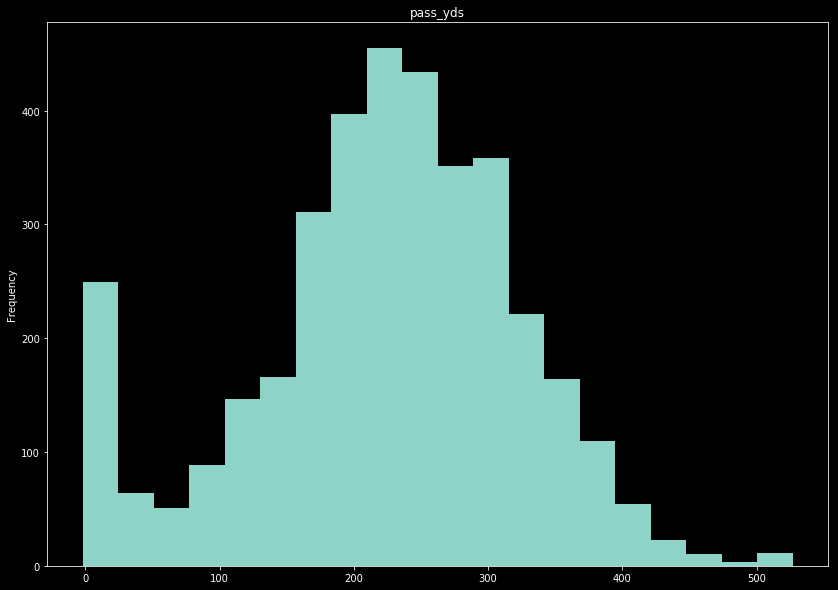

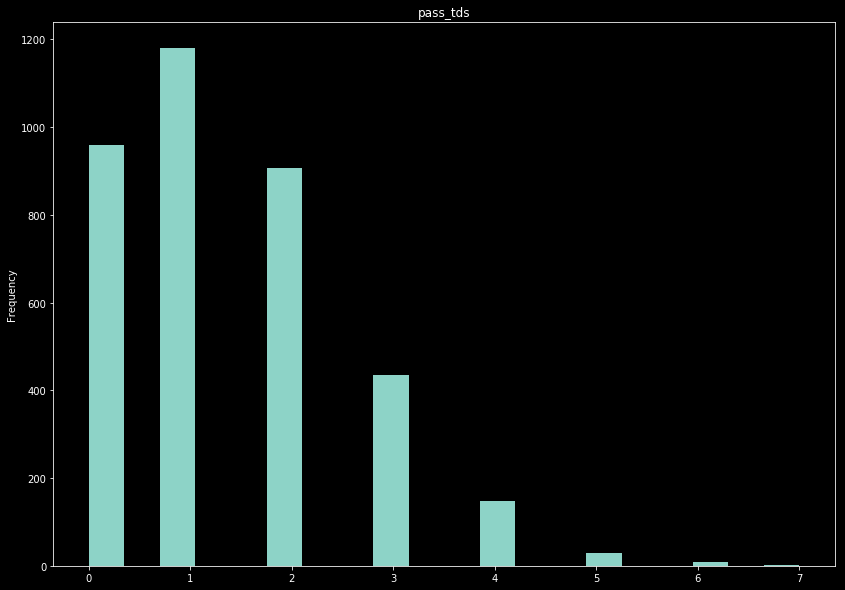

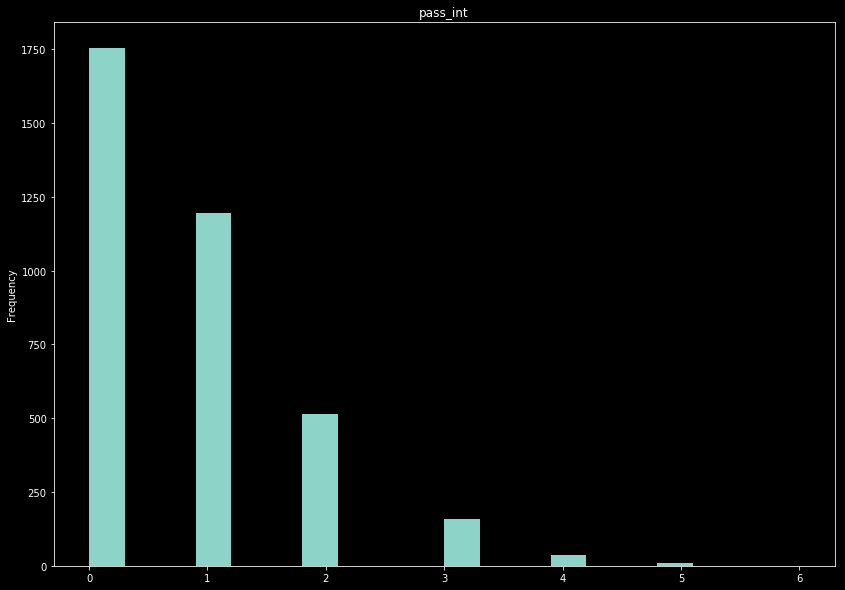

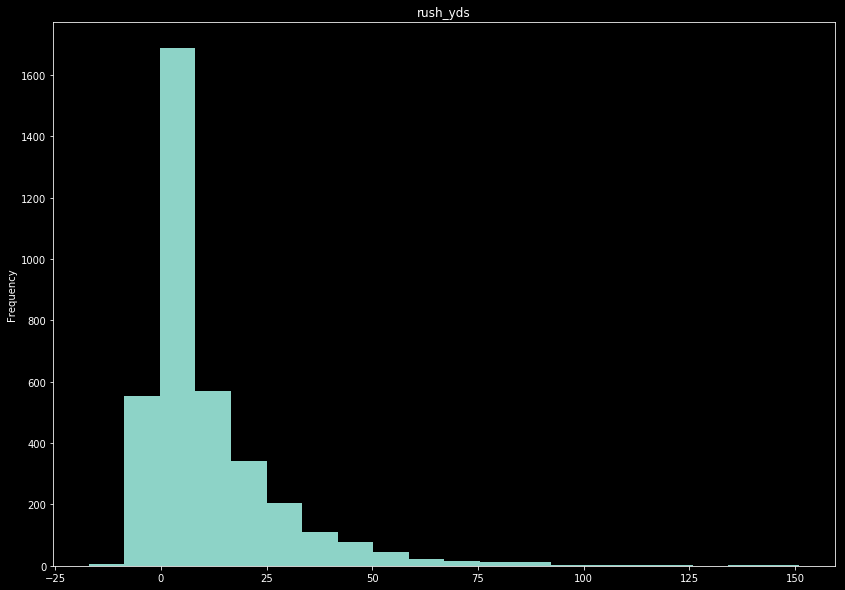

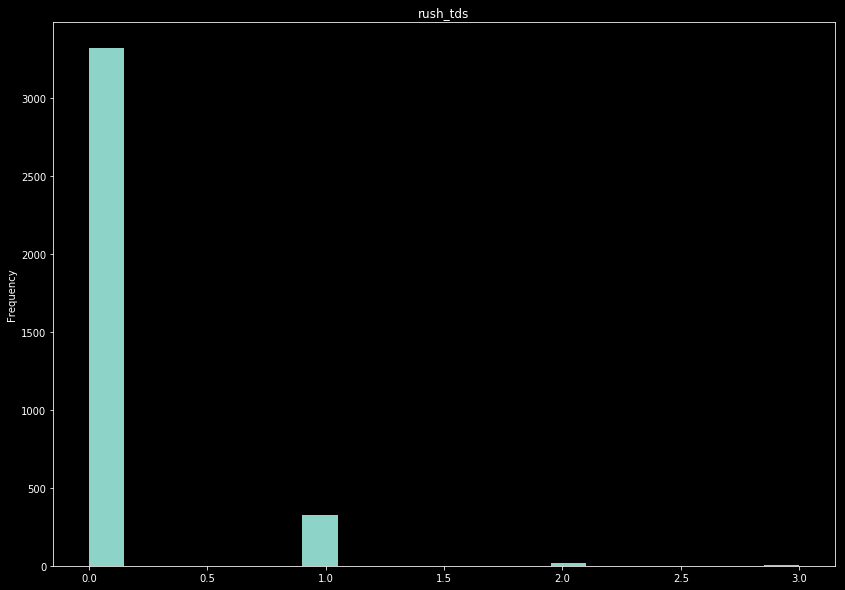

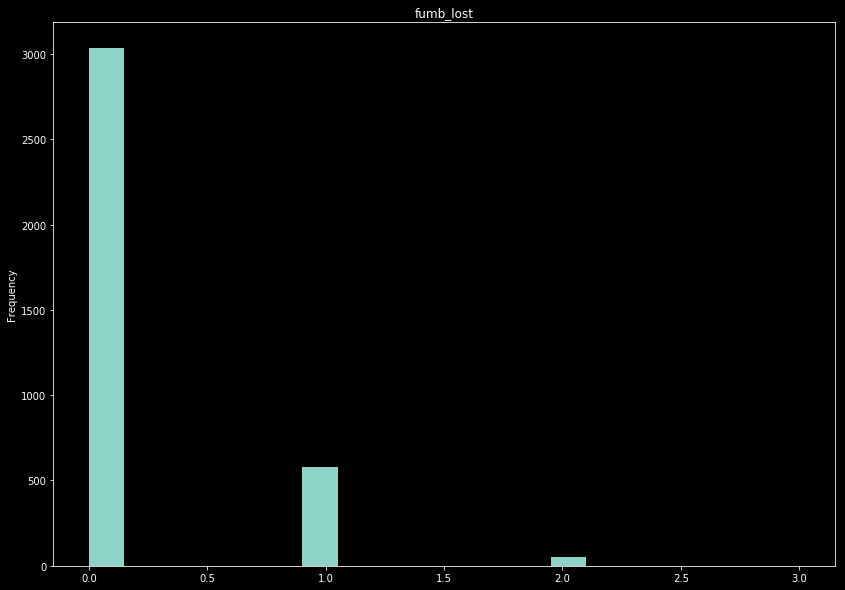

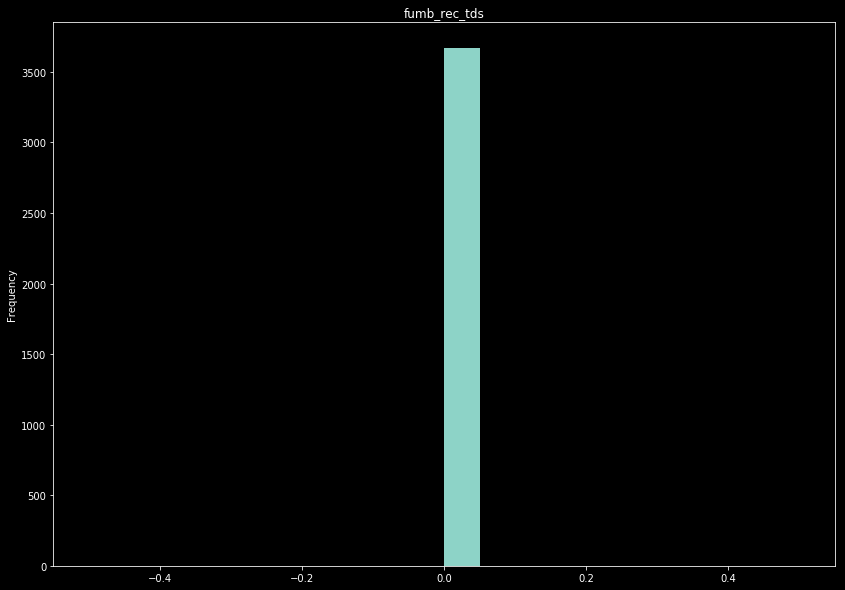

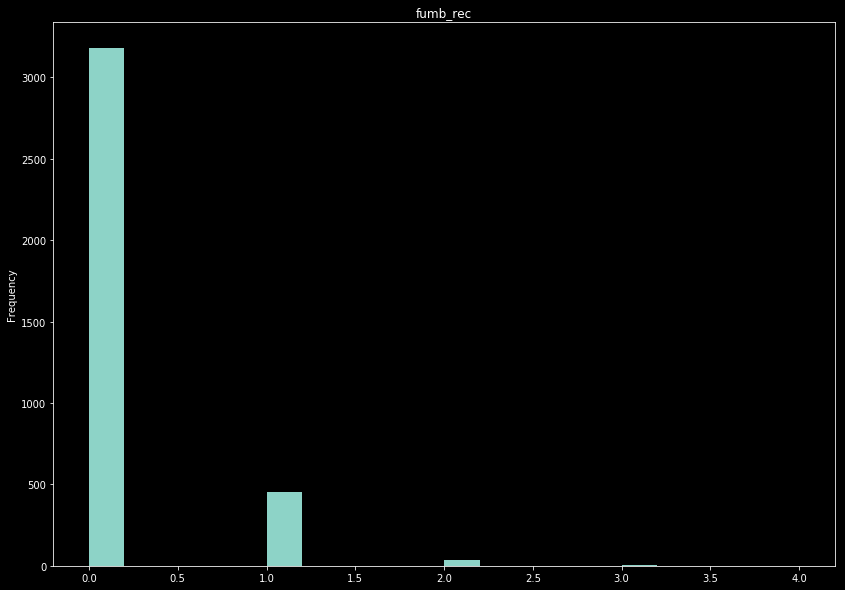

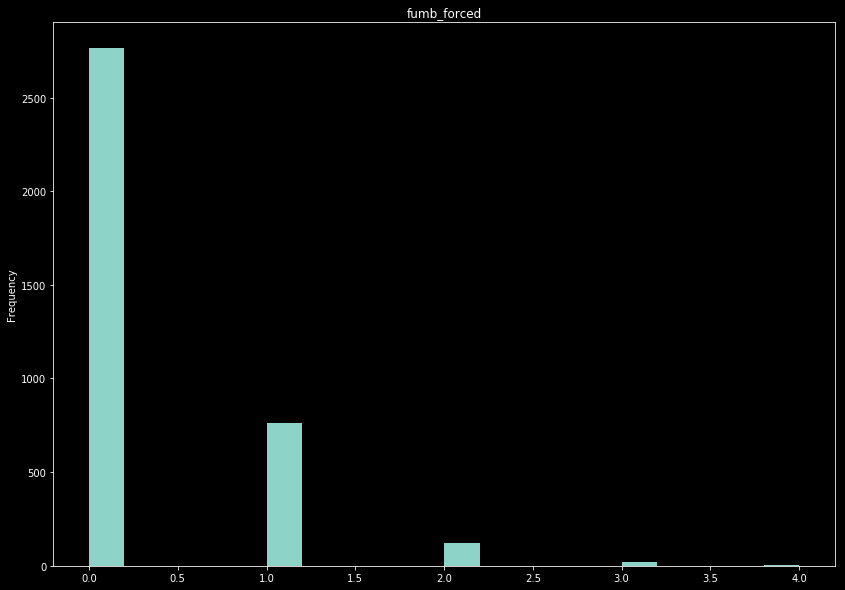

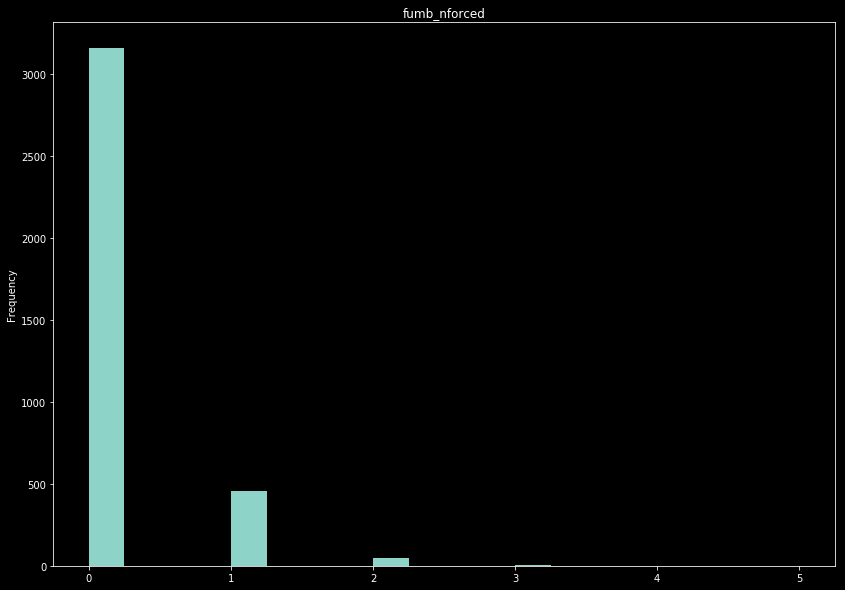

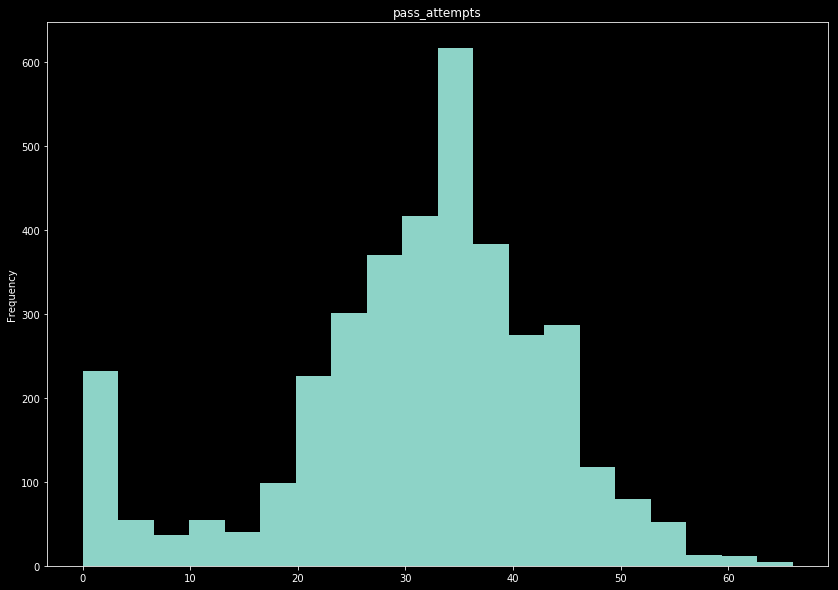

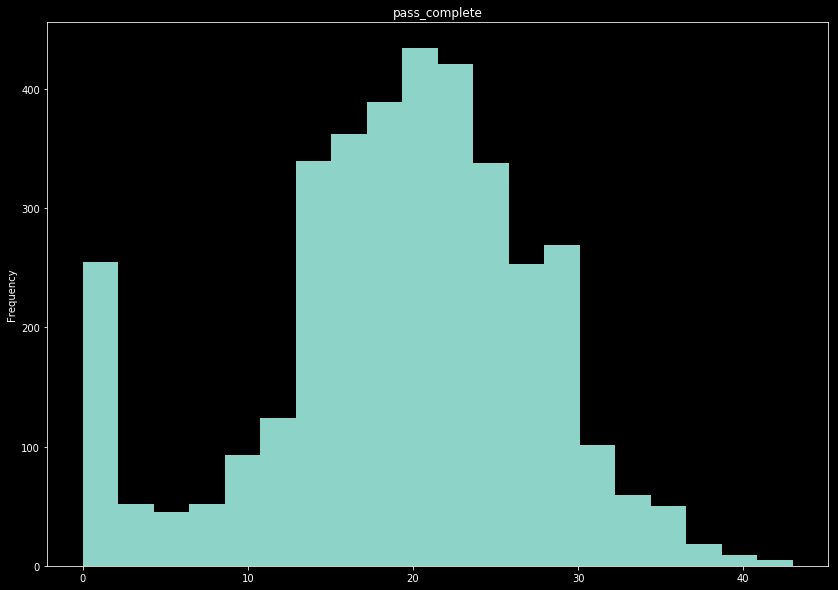

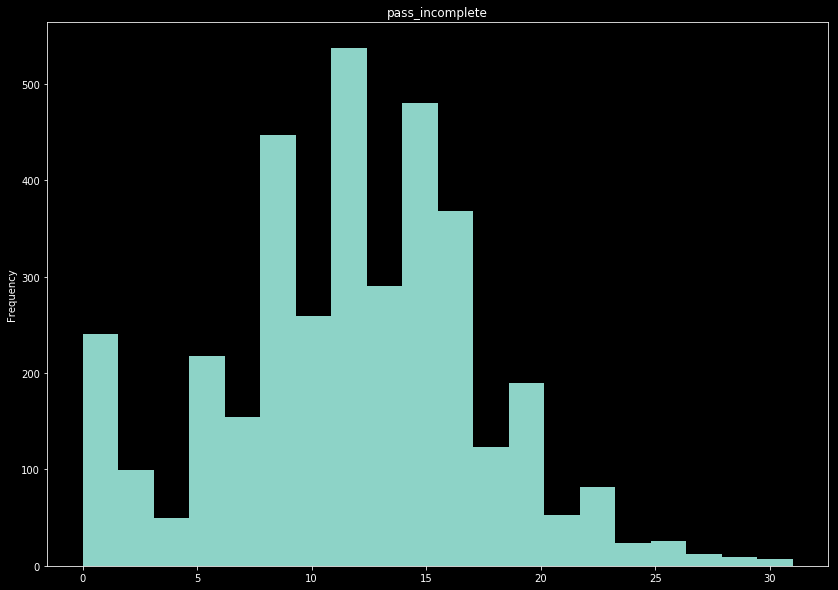

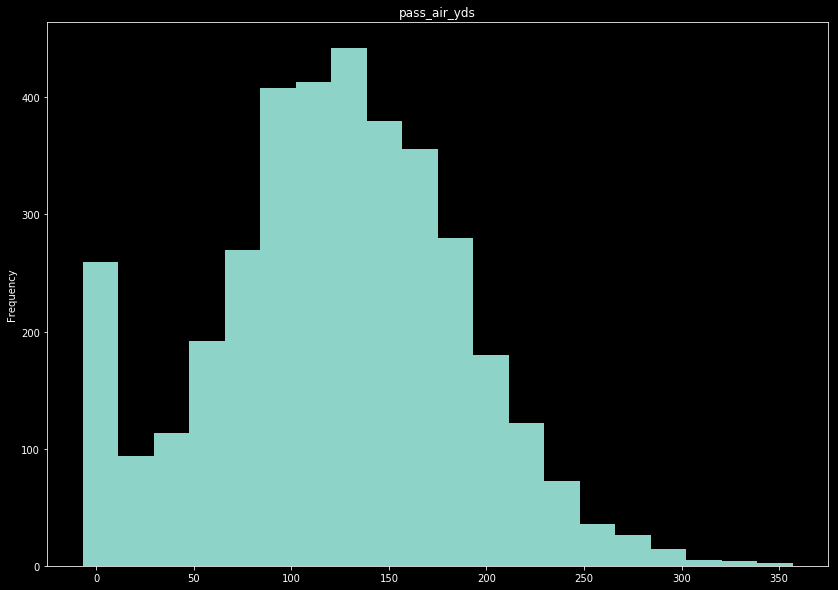

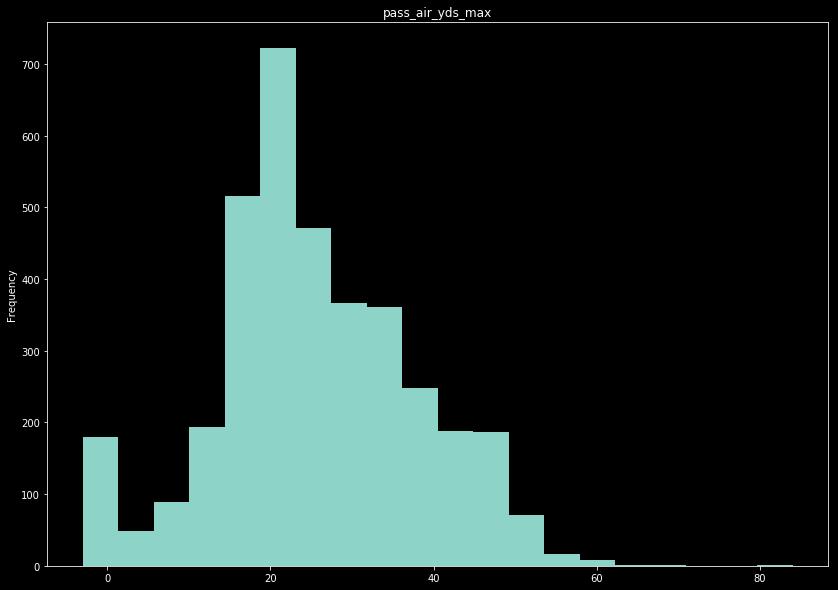

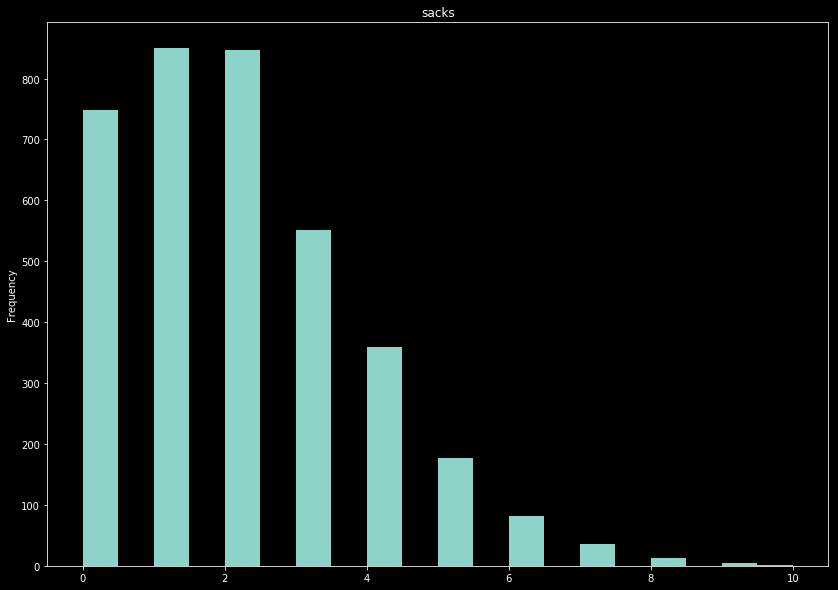

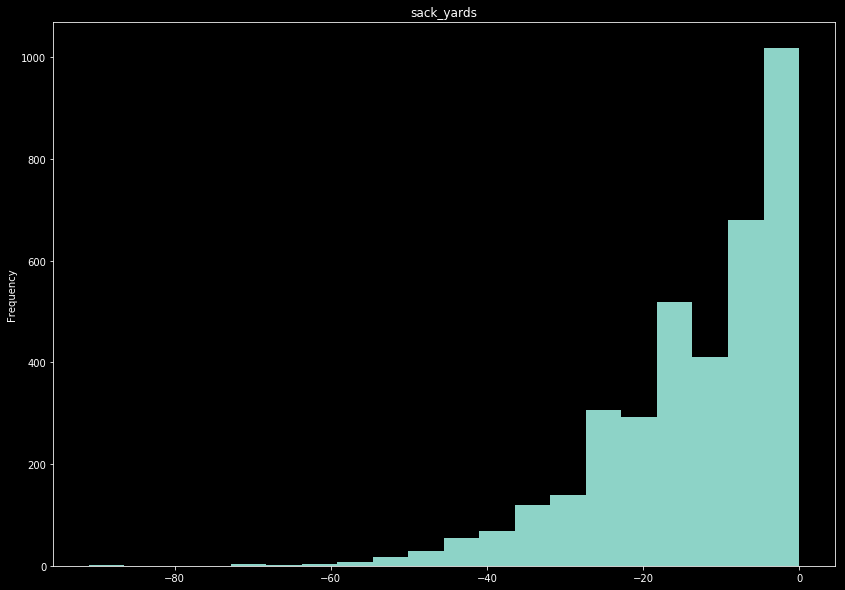

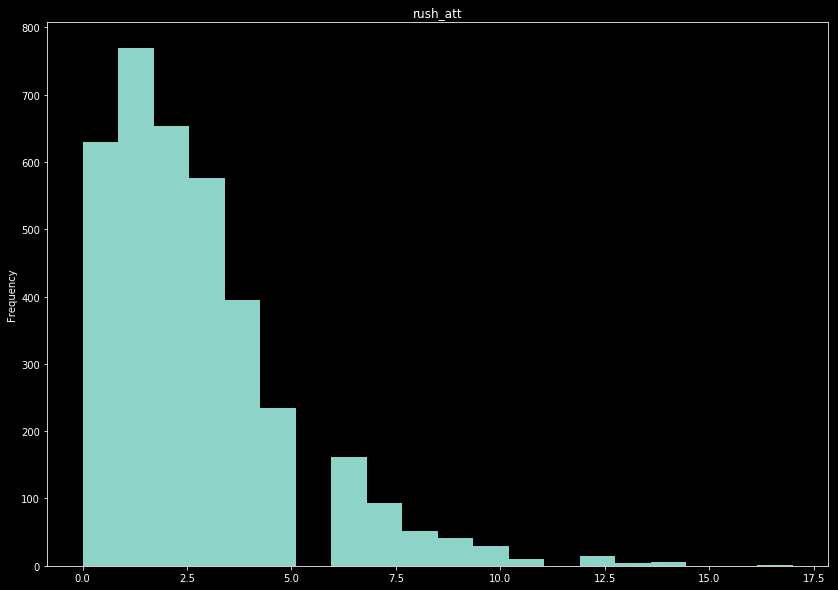

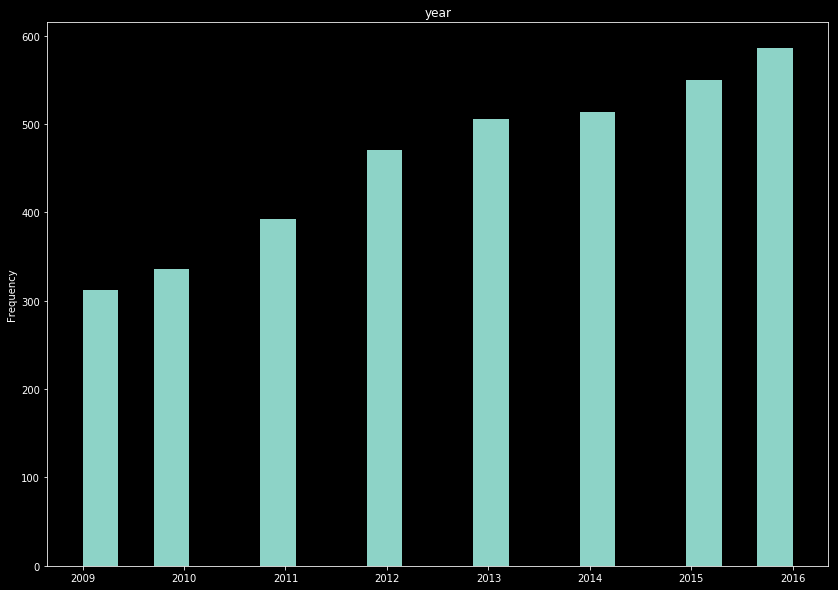

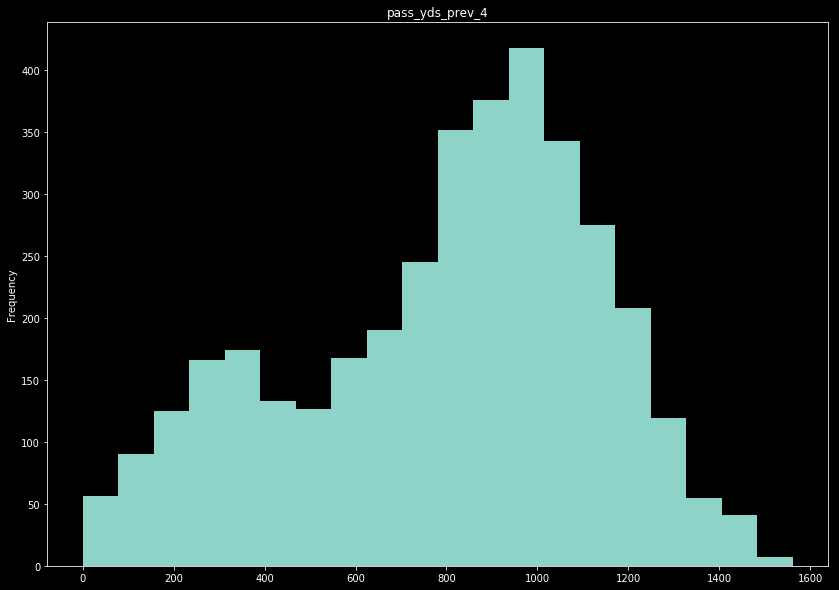

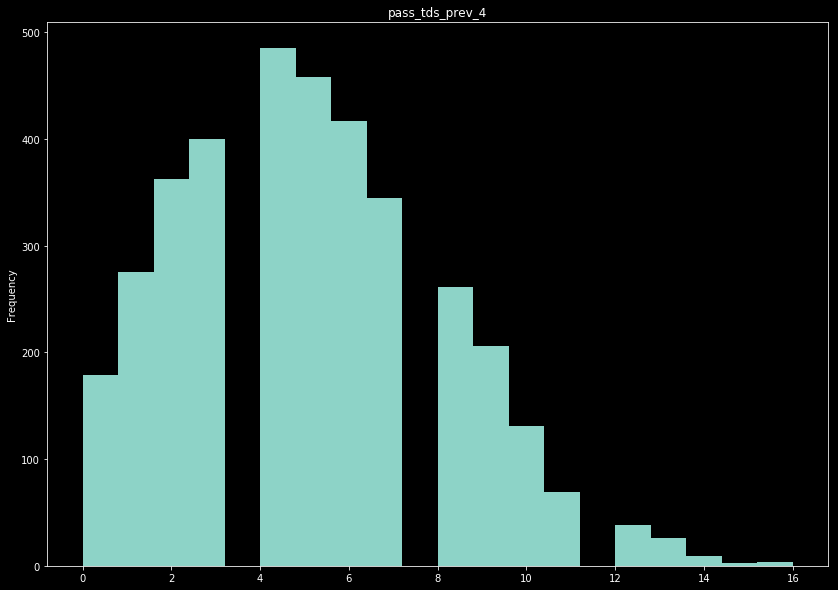

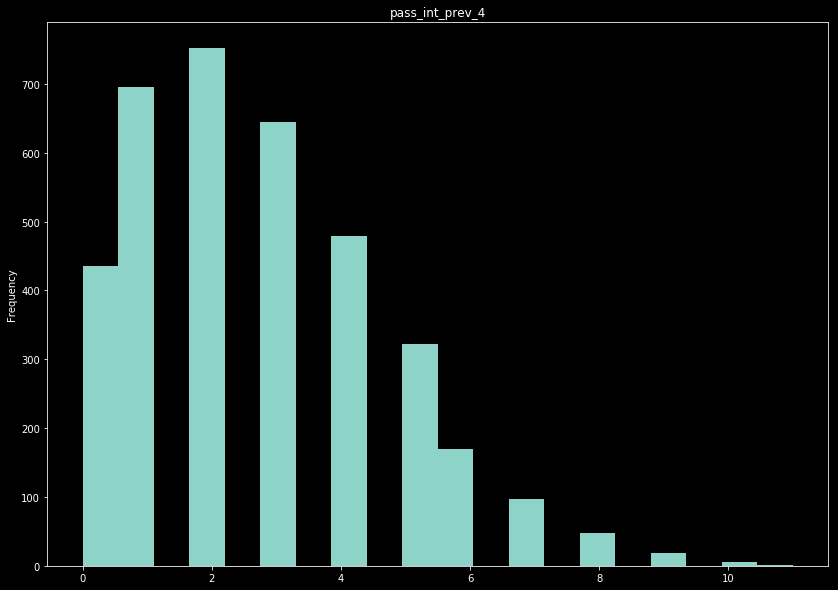

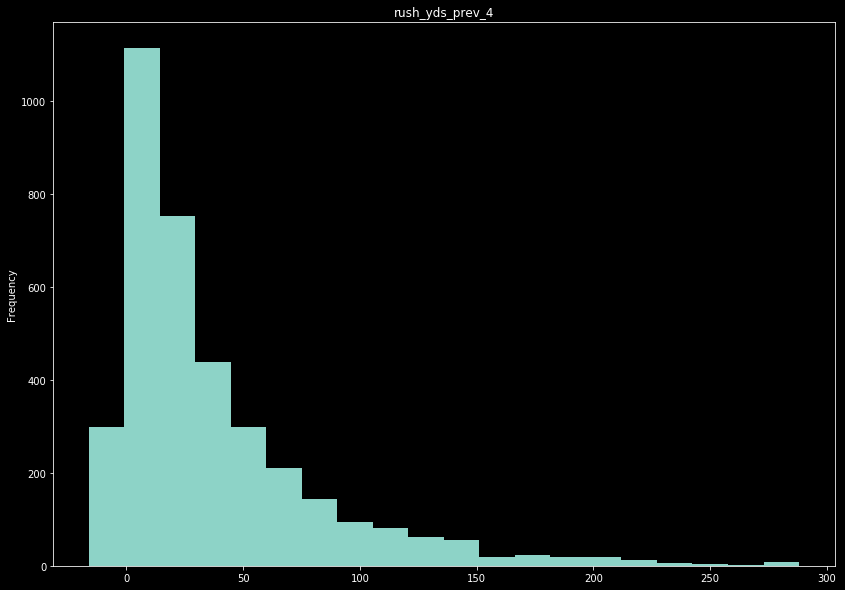

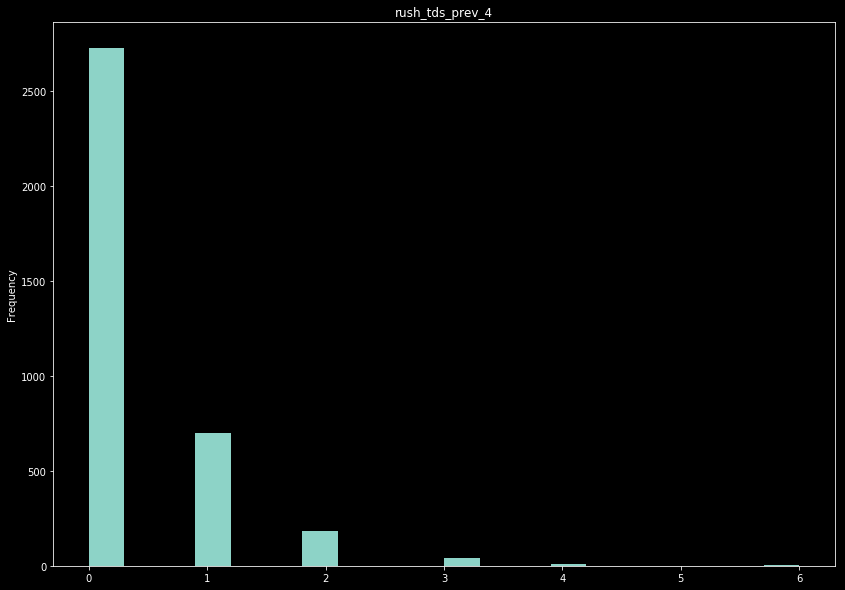

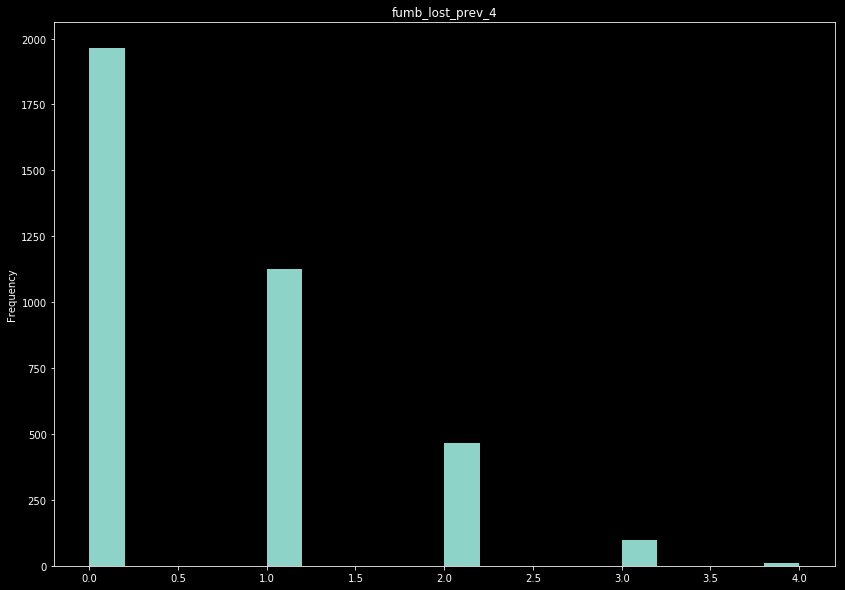

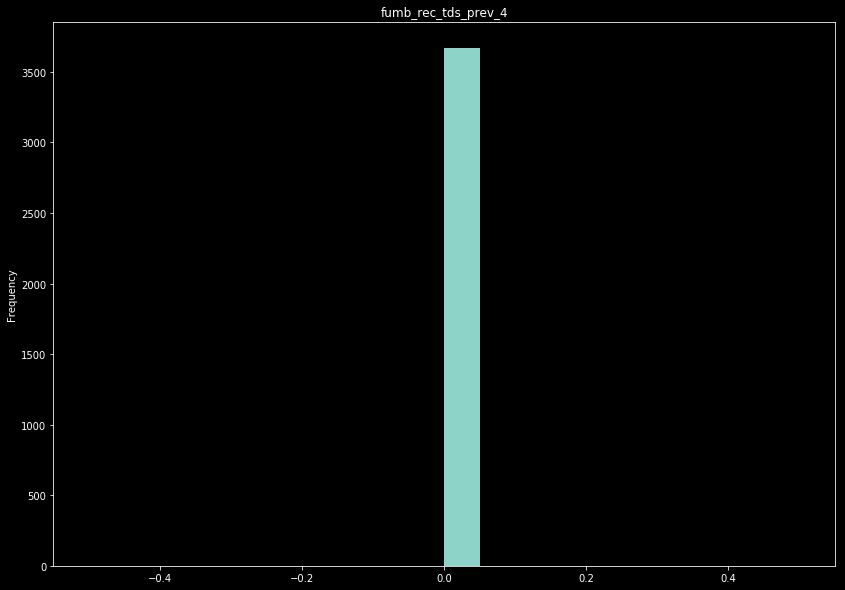

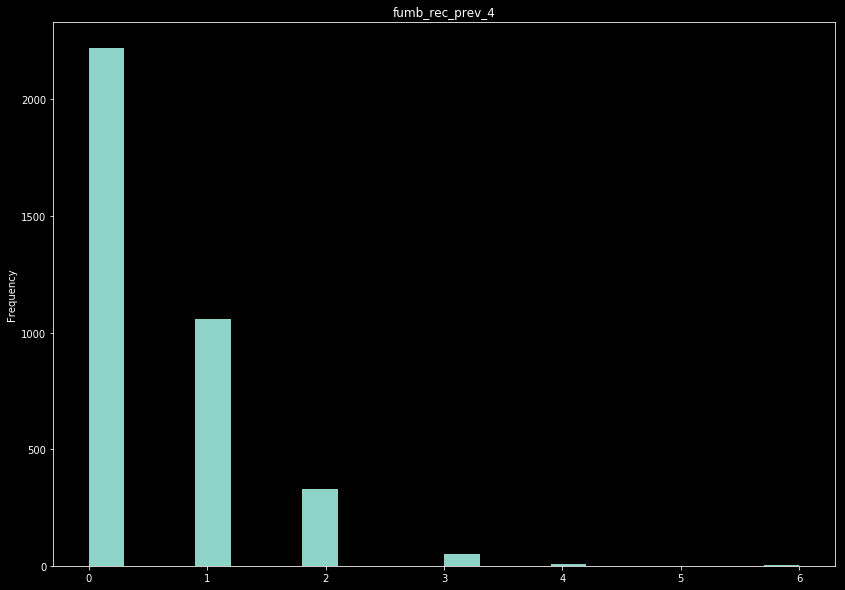

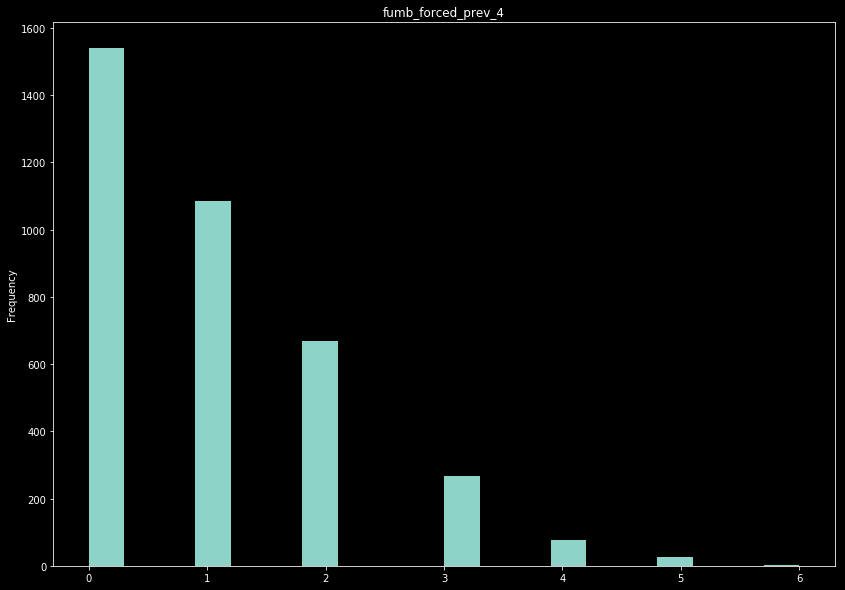

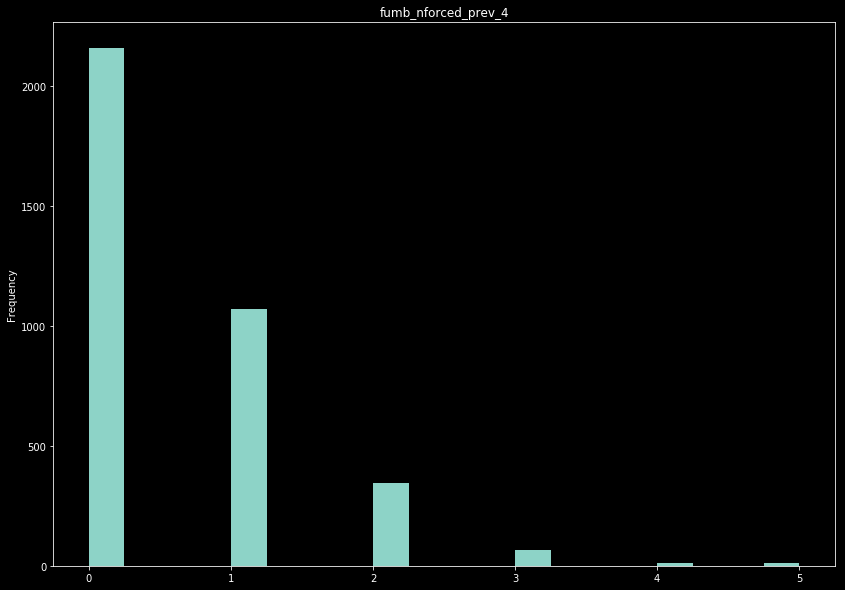

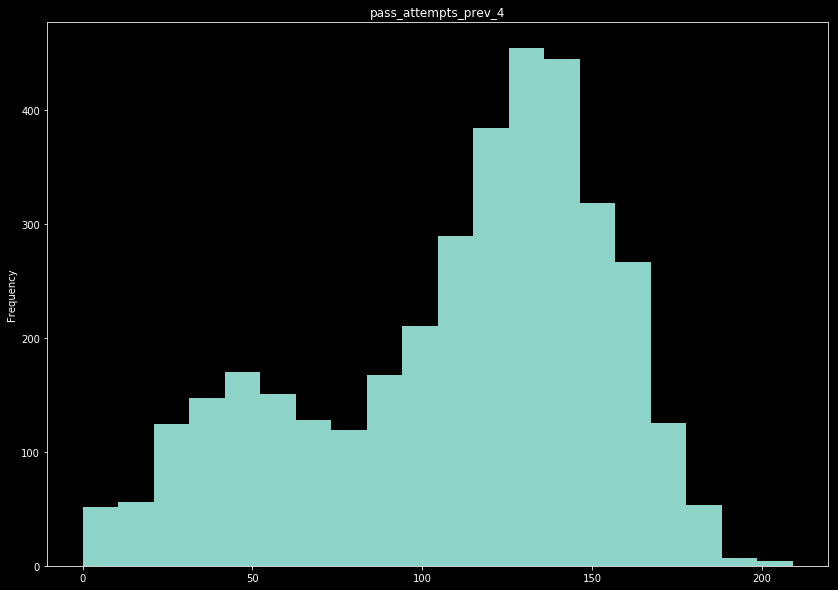

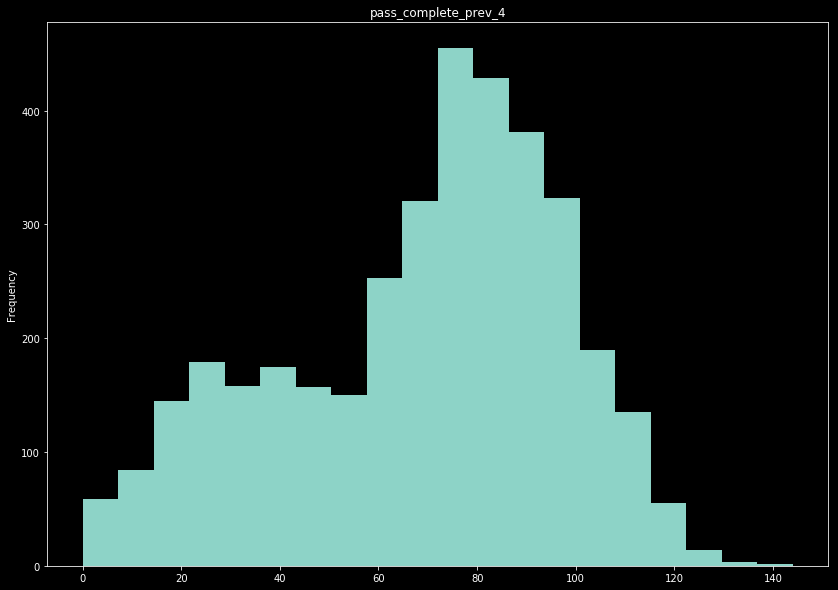

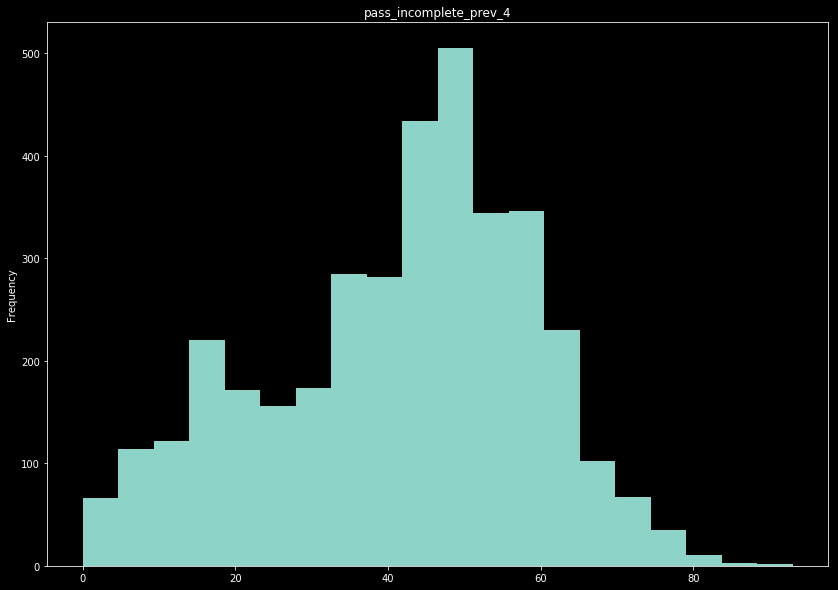

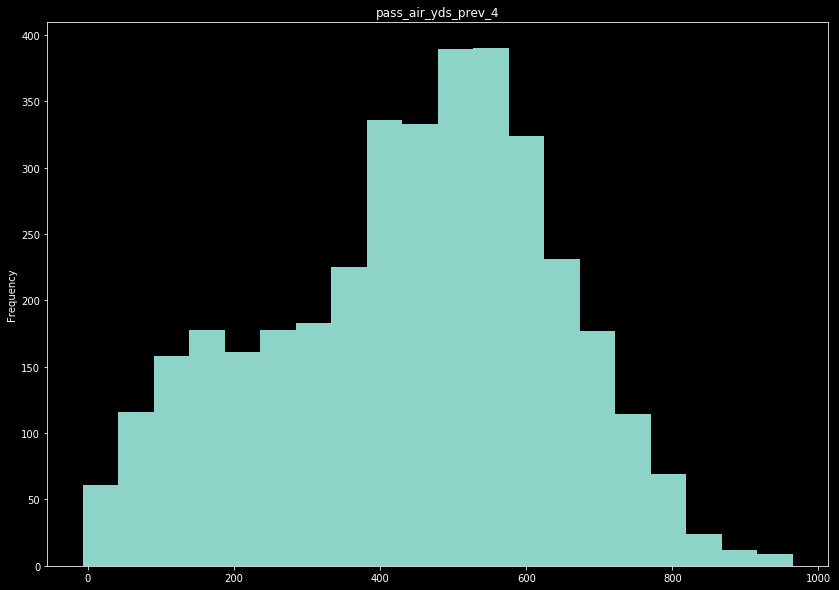

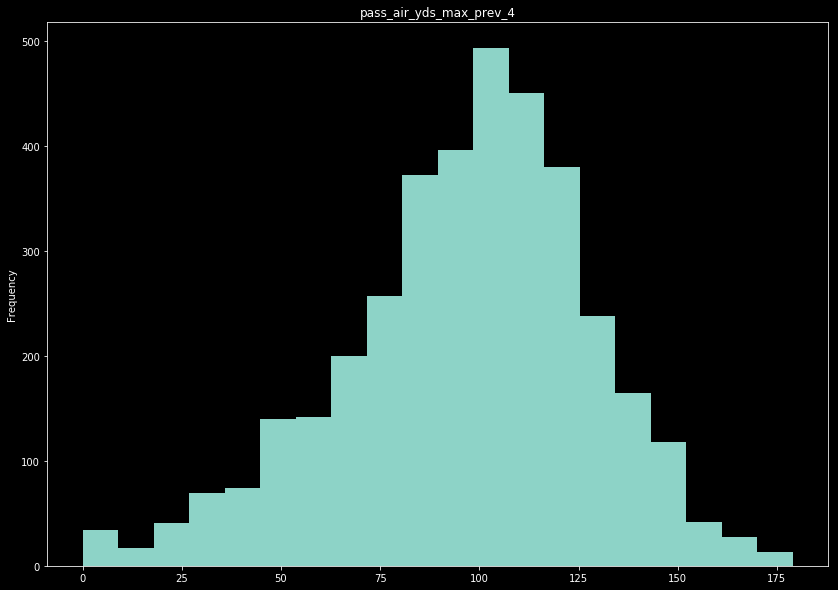

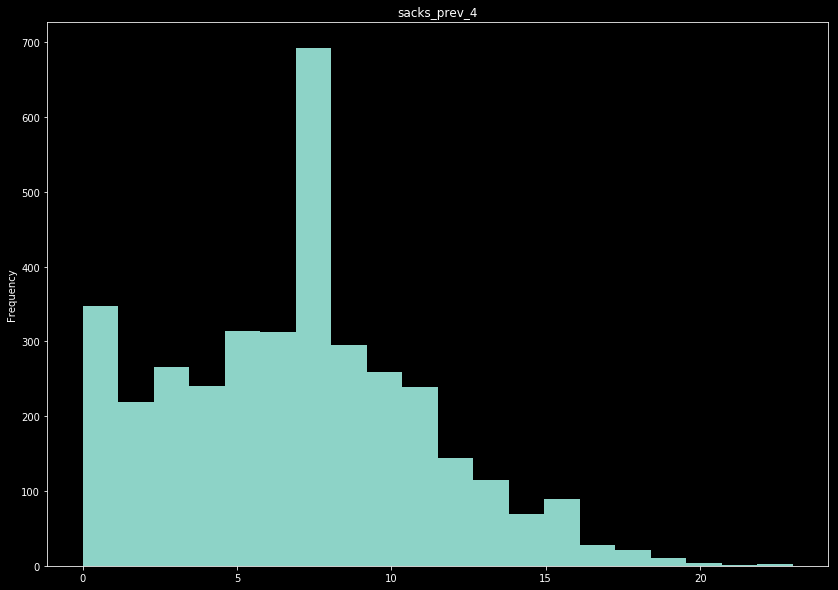

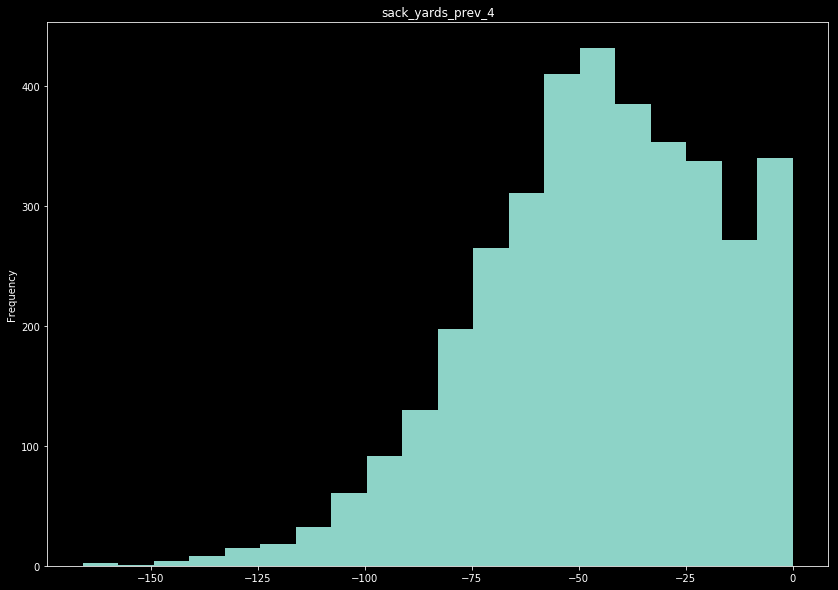

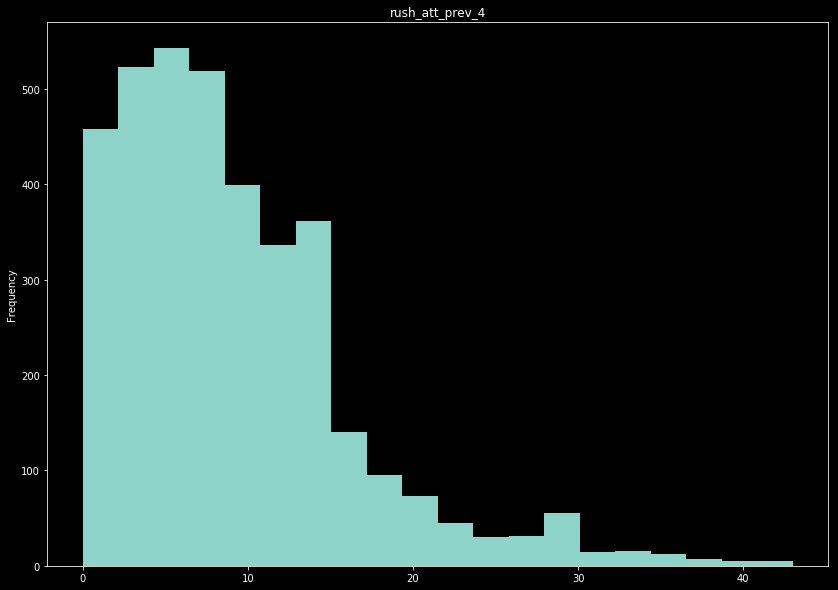

In [27]:
for col in all_qb_data.columns.values[3:]:
    all_qb_data[col].plot.hist(bins=20,title=col)
    plt.show()

Passing Yards: 1 point per 25 yards
    
Passing Touchdowns: 4 points
    
Passing Interceptions: -2 points
    
Rushing Yards: 1 point per 10 yards
    
Rushing Touchdowns: 6 points

Receptions: 1 points (only if using PPR scoring)

Receiving Yards: 1 point per 10 yards

Receiving Touchdowns: 6 points

2-Point Conversions: 2 points

Fumbles Lost: -2 points
    
Fumble Recovered for a Touchdown: 6 points

In [8]:
identifiers = [ 
                u'player_id', 
                u'team', 
                u'week', 
                'year'
              ]

scoring = [
             u'pass_yds', 
             u'pass_tds', 
             u'pass_int',
             u'rush_yds', 
             u'rush_tds', 
            # Reception stuff don't apply to qb, they pass
             u'fumb_lost'
            # Ignore fumb recover td
          ]

drop_non_agg = [
                 u'fumb_rec_tds',
                 u'fumb_rec',
                 u'fumb_forced' ,
                 u'fumb_nforced' ,
                 u'pass_attempts',
                 u'pass_complete',
                 u'pass_incomplete',
                 u'pass_air_yds',
                 u'pass_air_yds_max', 
                 u'sacks',
                 u'sack_yards' ,
                 u'rush_att'    
               ]

pass_agg = [
             'pass_yds_prev_'+wk_str, 
             'pass_tds_prev_'+wk_str,
             'pass_int_prev_'+wk_str,
             'pass_attempts_prev_'+wk_str,
             'pass_complete_prev_'+wk_str,
             'pass_incomplete_prev_'+wk_str,
             'pass_air_yds_prev_'+wk_str, 
             'pass_air_yds_max_prev_'+wk_str
           ]

rush_agg = [
             'rush_yds_prev_'+wk_str, 
             'rush_tds_prev_'+wk_str,
             'rush_att_prev_'+wk_str
           ]

fumb_agg = [
              'fumb_lost_prev_'+wk_str,
              'fumb_rec_tds_prev_'+wk_str, 
              'fumb_rec_prev_'+wk_str,
              'fumb_forced_prev_'+wk_str,
              'fumb_nforced_prev_'+wk_str  
           ]

sack_agg = [
             'sacks_prev_'+wk_str, 
             'sack_yards_prev_'+wk_str 
           ]

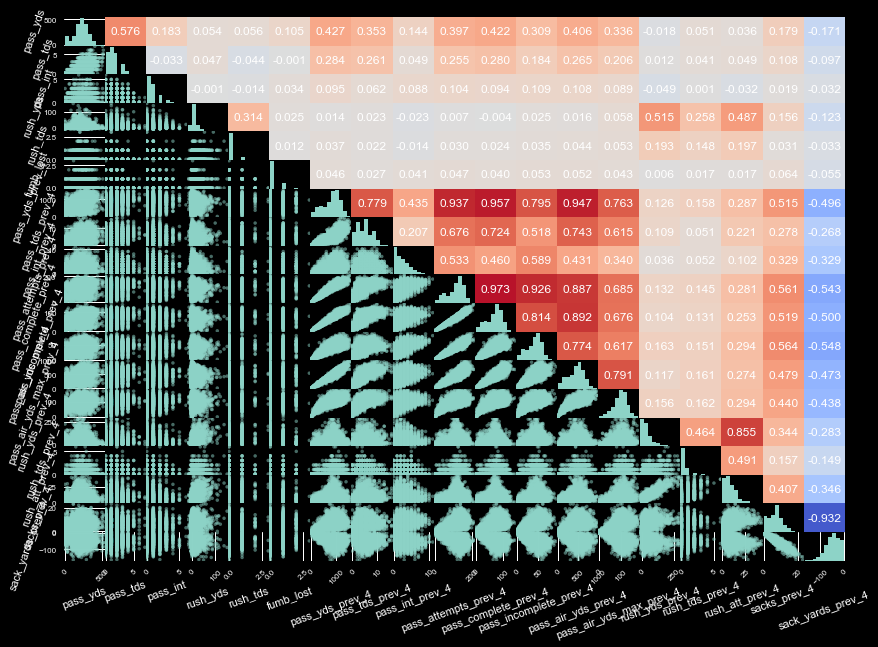

In [9]:
import df_visualizations as dv
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

dv.corr_plot( all_qb_data[ scoring+pass_agg+rush_agg+sack_agg] )

In [10]:
team_stats_df.columns.values

array([u'team', 'opp_team', u'week', 'year', 'score', 'opp_score',
       'home_flag', 'away_flag', 'tds', u'rush_att', u'rush_yds',
       u'pass_att', u'pass_yds', u'pass_cmp', u'pass_sack', u'kickoffs',
       u'punts', u'fg_miss', u'kickret_tds', u'punt_ret_tds',
       u'off_fumb_tot', u'kickoff_in_20', u'kickoff_touchback', u'fg_yds',
       u'fg_made', u'def_int_tds', u'def_frec_tds', u'def_misc_tds',
       u'def_safety', u'def_tkl', u'def_tkl_contributers', u'def_fumb_rec',
       u'def_fumb_forced', u'def_int', u'def_tkl_loss', u'def_sack',
       u'def_pass_def', 'score_prev_4', 'opp_score_prev_4',
       'home_flag_prev_4', 'away_flag_prev_4', 'tds_prev_4',
       'rush_att_prev_4', 'rush_yds_prev_4', 'pass_att_prev_4',
       'pass_yds_prev_4', 'pass_cmp_prev_4', 'pass_sack_prev_4',
       'kickoffs_prev_4', 'punts_prev_4', 'fg_miss_prev_4',
       'kickret_tds_prev_4', 'punt_ret_tds_prev_4', 'off_fumb_tot_prev_4',
       'kickoff_in_20_prev_4', 'kickoff_touchback_prev_4',

In [11]:
all_qb_data.columns.values

array([u'player_id', u'team', u'week', u'pass_yds', u'pass_tds',
       u'pass_int', u'rush_yds', u'rush_tds', u'fumb_lost',
       u'fumb_rec_tds', u'fumb_rec', u'fumb_forced', u'fumb_nforced',
       u'pass_attempts', u'pass_complete', u'pass_incomplete',
       u'pass_air_yds', u'pass_air_yds_max', u'sacks', u'sack_yards',
       u'rush_att', 'year', 'pass_yds_prev_4', 'pass_tds_prev_4',
       'pass_int_prev_4', 'rush_yds_prev_4', 'rush_tds_prev_4',
       'fumb_lost_prev_4', 'fumb_rec_tds_prev_4', 'fumb_rec_prev_4',
       'fumb_forced_prev_4', 'fumb_nforced_prev_4', 'pass_attempts_prev_4',
       'pass_complete_prev_4', 'pass_incomplete_prev_4',
       'pass_air_yds_prev_4', 'pass_air_yds_max_prev_4', 'sacks_prev_4',
       'sack_yards_prev_4', 'rush_att_prev_4'], dtype=object)

In [25]:
team_stuff = [ 
               'tds_prev_', 
               'fg_made_prev_', 
               'fg_miss_prev_', 
               'home_flag_prev_', 
               'away_flag_prev_',
               'kickoffs_prev_', 
               'punts_prev_' 
             ]

team_stuff = [ item+wk_str for item in team_stuff ]

new_frame = pd.merge( 
                      all_qb_data, 
                      team_stats_df[['team','week','year']+team_stuff], 
                      on=['team','week','year']
                    )

In [20]:
new_frame.columns.values

array([u'player_id', u'team', u'week', u'pass_yds', u'pass_tds',
       u'pass_int', u'rush_yds', u'rush_tds', u'fumb_lost',
       u'fumb_rec_tds', u'fumb_rec', u'fumb_forced', u'fumb_nforced',
       u'pass_attempts', u'pass_complete', u'pass_incomplete',
       u'pass_air_yds', u'pass_air_yds_max', u'sacks', u'sack_yards',
       u'rush_att', 'year', 'pass_yds_prev_4', 'pass_tds_prev_4',
       'pass_int_prev_4', 'rush_yds_prev_4', 'rush_tds_prev_4',
       'fumb_lost_prev_4', 'fumb_rec_tds_prev_4', 'fumb_rec_prev_4',
       'fumb_forced_prev_4', 'fumb_nforced_prev_4', 'pass_attempts_prev_4',
       'pass_complete_prev_4', 'pass_incomplete_prev_4',
       'pass_air_yds_prev_4', 'pass_air_yds_max_prev_4', 'sacks_prev_4',
       'sack_yards_prev_4', 'rush_att_prev_4', 'tds_prev_4',
       'fg_made_prev_4', 'fg_miss_prev_4', 'home_flag_prev_4',
       'away_flag_prev_4', 'kickoffs_prev_4', 'punts_prev_4'], dtype=object)

In [26]:
team_rename_list = [
                    'tds_prev_', 'fg_made_prev_', 
                    'fg_miss_prev_', 'home_flag_prev_',
                    'away_flag_prev_', 'kickoffs_prev_', 
                    'punts_prev_'
                   ]

team_rn_dict = dict( zip( team_rename_list, ['team_'+item+wk_str for item in team_rename_list] ) )

new_frame['pass_att_prev_'+wk_str] = new_frame['pass_attempts_prev_'+wk_str]
    
new_frame = new_frame[[
                        'player_id','team','week','year',
                        'rush_yds', 'rush_tds',
                        'pass_yds', 'pass_tds', 'pass_int',
                        'fumb_lost',
                        'few_reg_weeks',
    
                        'pass_complete_prev_'+wk_str, 'pass_incomplete_prev_'+wk_str, 'pass_int_prev_'+wk_str,
                        'pass_air_yds_prev_'+wk_str, 'pass_air_yds_max_prev_'+wk_str,
    
                        'pass_yds_prev_'+wk_str, 'pass_tds_prev_'+wk_str, 'pass_att_prev_'+wk_str, 
                        'rush_yds_prev_'+wk_str, 'rush_tds_prev_'+wk_str, 'rush_att_prev_'+wk_str,

                        'fumb_lost_prev_'+wk_str, 'fumb_rec_prev_'+wk_str, 'fumb_rec_tds_prev_'+wk_str, 
                        'fumb_forced_prev_'+wk_str, 'fumb_nforced_prev_'+wk_str,
    
                        'sacks_prev_'+wk_str, 'sack_yards_prev_'+wk_str,

                        'home_flag_prev_'+wk_str, 'away_flag_prev_'+wk_str,
                        'tds_prev_'+wk_str, 'fg_made_prev_'+wk_str, 'fg_miss_prev_'+wk_str,
                        'kickoffs_prev_'+wk_str, 'punts_prev_'+wk_str
                     ]]

new_frame = new_frame.rename( index=str, columns=team_rn_dict )

In [4]:
# Let's create opposing team stats...
opp_agg = ['tds','fg_made','rush_yds','pass_yds','def_tkl_loss','def_sack','def_pass_def']

opp_df = aps.calc_opp_avg( team_stats_df, opp_agg )
opp_df.head()

,opp_avg_tds_prev_4,opp_avg_fg_made_prev_4,opp_avg_rush_yds_prev_4,opp_avg_pass_yds_prev_4,opp_avg_def_tkl_loss_prev_4,opp_avg_def_sack_prev_4,opp_avg_def_pass_def_prev_4,team,year,week
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARI,2009,-3
1,2.500000,2.500000,124.000000,224.250000,4.250000,2.000000,4.250000,ARI,2009,-2
2,4.500000,2.500000,179.000000,565.250000,9.250000,2.000000,11.250000,ARI,2009,-1
3,7.500000,3.500000,348.000000,747.250000,14.750000,5.500000,17.250000,ARI,2009,0
1036,9.166667,4.833333,442.666667,968.583333,18.416667,7.833333,21.583333,ARI,2009,1


In [7]:
# Generates the QB features
# Mostly previous performance
def generate_qb_features( end_year, n_weeks=4, start_year=2009 ):

    
    # Rename some parameters
    min_year = start_year
    max_year =   end_year
    wk_str   = str(n_weeks)        

    # For the QB SQL query
    all_qb_data = pd.DataFrame()

    # Get all the preseason data
    # Can id by team, week, year
    for year in range( min_year, max_year ):
        new_frame = gps.generate_stats( 'QB', year, season_type='Preseason' )
        new_frame['year'] = year
        all_qb_data = pd.concat( [all_qb_data, new_frame], ignore_index=True )

    # Rebrand preseason week
    all_qb_data['week'] = all_qb_data['week']-4

    # Get all the QB regular season data
    # Can id by team, week, year
    for year in range( min_year, max_year ):
        new_frame = gps.generate_stats( 'QB', year )
        new_frame['year'] = year
        all_qb_data = pd.concat( [all_qb_data, new_frame], ignore_index=True )

    # Ignore some team stuff, can get from joining with team
    all_qb_data = all_qb_data.drop( ['opp_team','home_flag','away_flag'],axis=1 )

    # Generate previous rolling sum
    agg_stuff = [
                    'pass_yds', 'pass_tds', 'pass_int', 
                    'rush_yds', 'rush_tds', 'rush_att',
                    'fumb_lost','fumb_rec_tds','fumb_rec','fumb_forced','fumb_nforced',
                    'pass_attempts', 'pass_complete','pass_incomplete',
                    'pass_air_yds', 'pass_air_yds_max', 
                    'sacks', 'sack_yards'
                ]
    
    # Rolling sums from previous games
    prev_qb = aps.calc_prev_player_stats( all_qb_data, agg_stuff )

    # Combine present values with rolling sums
    all_qb_data = pd.merge( all_qb_data, prev_qb, on=['player_id','year','week'] )

    # Drop all the preseason stuff
    all_qb_data = all_qb_data.loc[ all_qb_data['week']>0 ]

    # Note if the data includes preseason stuff
    # If the first four games, flag as preseason data included
    # This is tricky, as can have a bye-week
    # Therefore, group things, find the first n_weeks, and flag those as 1
    inds = all_qb_data.groupby(['player_id','year'], as_index=False).nth( range(0, n_weeks) ).index.values

    all_qb_data    [       'few_reg_weeks'] = 0
    all_qb_data.loc[ inds, 'few_reg_weeks'] = 1
    
    
    # Generate team stats
#aps
    team_stats_df = aps.generate_full_team_aggregate( end_year, drop_preseason=False )

    # Stuff to grab from team df
    team_stuff = [ 
                   'tds_prev_', 
                   'fg_made_prev_', 
                   'fg_miss_prev_', 
                   'home_flag_prev_', 
                   'away_flag_prev_',
                   'kickoffs_prev_', 
                   'punts_prev_' 
                 ]
    team_stuff = [ item+wk_str for item in team_stuff ]

    
    temp_frame = pd.merge( 
                           all_qb_data, 
                           team_stats_df[['team','week','year']+team_stuff], 
                           on=['team','week','year']
                         )
    
    # For some reason att written as attempts
    temp_frame['pass_att_prev_'+wk_str] = temp_frame['pass_attempts_prev_'+wk_str]

    # Stuff to grab
    reorg_stuff = [
                    'pass_complete_prev_', 'pass_incomplete_prev_' , 'pass_int_prev_',
                    'pass_air_yds_prev_' , 'pass_air_yds_max_prev_',

                    'pass_yds_prev_', 'pass_tds_prev_', 'pass_att_prev_', 
                    'rush_yds_prev_', 'rush_tds_prev_', 'rush_att_prev_',

                    'fumb_lost_prev_'  , 'fumb_rec_prev_'    , 'fumb_rec_tds_prev_', 
                    'fumb_forced_prev_', 'fumb_nforced_prev_',

                    'sacks_prev_', 'sack_yards_prev_',

                    'home_flag_prev_', 'away_flag_prev_',
                    'tds_prev_', 'fg_made_prev_', 'fg_miss_prev_',
                    'kickoffs_prev_', 'punts_prev_'
                  ]
    reorg_stuff = [ item+wk_str for item in reorg_stuff ]
    
    # Re-organize the frame
    new_frame = temp_frame[[
                            'player_id','team','week','year',
                            'rush_yds', 'rush_tds',
                            'pass_yds', 'pass_tds', 'pass_int',
                            'fumb_lost',
                            'few_reg_weeks',
                           ]

                            +reorg_stuff
                          ]
    
    # Stuff to rename from the team frame
    team_rn_dict = dict( zip( team_stuff, ['team_'+item for item in team_stuff] ) )

    
    # Opposition stuff to grab
    # May have low/hi stats due to tough/weak teams
    opp_agg = ['tds','fg_made','rush_yds','pass_yds','def_tkl_loss','def_sack','def_pass_def']
#aps
    opp_df = aps.calc_opp_avg( team_stats_df, opp_agg )
    
    
    # Rename some more rows
    new_frame = new_frame.rename( index=str, columns=team_rn_dict )
        
    new_frame = pd.merge( new_frame, 
                          opp_df   ,
                          on=['team','week','year'],
                          how='left'
                        )
    
    return new_frame

(3668, 36)
[u'player_id' u'team' u'week' 'year' u'rush_yds' u'rush_tds' u'pass_yds'
 u'pass_tds' u'pass_int' u'fumb_lost' 'few_reg_weeks'
 'pass_complete_prev_4' 'pass_incomplete_prev_4' 'pass_int_prev_4'
 'pass_air_yds_prev_4' 'pass_air_yds_max_prev_4' 'pass_yds_prev_4'
 'pass_tds_prev_4' 'pass_att_prev_4' 'rush_yds_prev_4' 'rush_tds_prev_4'
 'rush_att_prev_4' 'fumb_lost_prev_4' 'fumb_rec_prev_4'
 'fumb_rec_tds_prev_4' 'fumb_forced_prev_4' 'fumb_nforced_prev_4'
 'sacks_prev_4' 'sack_yards_prev_4' 'team_home_flag_prev_4'
 'team_away_flag_prev_4' 'team_tds_prev_4' 'team_fg_made_prev_4'
 'team_fg_miss_prev_4' 'team_kickoffs_prev_4' 'team_punts_prev_4']
(3668, 43)
[u'player_id' u'team' u'week' 'year' u'rush_yds' u'rush_tds' u'pass_yds'
 u'pass_tds' u'pass_int' u'fumb_lost' 'few_reg_weeks'
 'pass_complete_prev_4' 'pass_incomplete_prev_4' 'pass_int_prev_4'
 'pass_air_yds_prev_4' 'pass_air_yds_max_prev_4' 'pass_yds_prev_4'
 'pass_tds_prev_4' 'pass_att_prev_4' 'rush_yds_prev_4' 'rush_tds_prev